In [1]:
#imports
import matplotlib.pyplot as plt
import astropy.io
from astropy.io import fits
from astropy import wcs
import numpy as np
from numpy import append
import healpy as hp
from cosmology import *
from scipy.interpolate import *
import pixell
from pixell import reproject, enplot, enmap, utils

In [2]:
# variables for Halo catalog
omegab = 0.049
omegac = 0.261
omegam = omegab + omegac
h      = 0.68
ns     = 0.965
sigma8 = 0.81
c = 3e5
H0 = 100*h
nz = 100000
z1 = 0.0
z2 = 6.0
za = np.linspace(z1,z2,nz)
dz = za[1]-za[0]
H = lambda z: H0*np.sqrt(omegam*(1+z)**3+1-omegam)
dchidz = lambda z: c/H(z)
chia = np.cumsum(dchidz(za))*dz
zofchi = interp1d(chia,za)
rho = 2.775e11*omegam*h**2 # Msun/Mpc^3d

In [3]:
# Opens fits files that aren't in alm form
def read_healpy_normal(file):
    return hp.read_map(file)

# Uses healpy to graph fits files that aren't in alm form
def display_healpy_normal(file): 
    return hp.gnomview(read_healpy_normal(file))

# Opens fits files that are in alm form
def read_healpy_alm(file):
    A1 = hp.read_alm(file)
    NSIDE1 = 1024
    return hp.alm2map(A1,NSIDE1)

# Uses healpy to graph fits files that are in alm form
def display_healpy_alm(file): 
    return hp.gnomview(read_healpy_alm(file))

In [4]:
# Converts to an enmap
def read_enmap_normal(file):
    shape, wcs = enmap.fullsky_geometry(res=0.5 * utils.arcmin, proj='car')
    iheal = read_healpy_normal(file)
    iheal = iheal.astype(np.float32)
    return reproject.healpix2map(iheal,shape,wcs)

# Graphs enmap using pixell
def display_enmap_normal(file):
    shape, wcs = enmap.fullsky_geometry(res=0.5 * utils.arcmin, proj='car')
    iheal = read_healpy_normal(file)
    iheal = iheal.astype(np.float32)
    enmap_map = reproject.healpix2map(iheal,shape,wcs)
    return plt.imshow(enmap_map)

# Converts to an enmap for alm files
def read_enmap_alm(file):
    shape, wcs = enmap.fullsky_geometry(res=0.5 * utils.arcmin, proj='car')
    iheal = read_healpy_alm(file)
    iheal = iheal.astype(np.float32)
    return reproject.healpix2map(iheal,shape,wcs)

# Graphs enmap using pixell for alm files
def display_enmap_alm(file):
    shape, wcs = enmap.fullsky_geometry(res=0.5 * utils.arcmin, proj='car')
    iheal = read_healpy_alm(file)
    iheal = iheal.astype(np.float32)
    enmap_map = reproject.healpix2map(iheal,shape,wcs)
    return plt.imshow(enmap_map)

In [5]:
#ONLY RUN ONCE

# Defines shape and wcs for a full sky projection
shape, wcs = enmap.fullsky_geometry(res=0.5 * utils.arcmin, proj='car')

# Creates a variable for the kappa enmap
iheal_kap = read_healpy_normal('kap.fits')
iheal_kap = iheal_kap.astype(np.float32)
enmap_map_kaps = reproject.healpix2map(iheal_kap,shape,wcs)

# Creates a variable for the tsz enmap
iheal_tsz = read_healpy_normal('tsz.fits')
iheal_tsz = iheal_tsz.astype(np.float32)
enmap_map_tsz = reproject.healpix2map(iheal_tsz,shape,wcs)

# Creates a variable for the lensed enmap
iheal_lensed = read_healpy_alm('lensed_alm.fits')
iheal_lensed = iheal_lensed.astype(np.float32)
enmap_map_lensed = reproject.healpix2map(iheal_lensed,shape,wcs)

In [6]:
# ONLY RUN ONCE
# Opens the first N terms in the Halos Catalog
f=open('halos.pksc')
N = 1000
Nhalo = np.fromfile(f, count=3, dtype=np.int32)[0]
catalog=np.fromfile(f,count=N*10,dtype=np.float32)

In [7]:
# Converts catalog data into a useful form
# Theta = colatitude, phi = longitude
catalog=np.reshape(catalog,(N,10))
x  = catalog[:,0];  y = catalog[:,1];  z = catalog[:,2] # Mpc (comoving)
vx = catalog[:,3]; vy = catalog[:,4]; vz = catalog[:,5] # km/sec
R  = catalog[:,6] # Mpc

# convert to mass, comoving distance, radial velocity, redshfit, RA and DEc
M200m    = 4*np.pi/3.*rho*R**3        # this is M200m (mean density 200 times mean) in Msun
chi      = np.sqrt(x**2+y**2+z**2)    # Mpc
vrad     = (x*vx + y*vy + z*vz) / chi # km/sec
redshift = zofchi(chi)  
theta, phi  = hp.vec2ang(np.column_stack((x,y,z))) # in radians

In [8]:
# Creates a list of masses
mass_list = []
for j in range(N):
    mass_list.append(M200m[j])

(array([  0., 371., 257., 138.,  82.,  55.,  29.,  26.,  10.]),
 array([1.00000000e+15, 1.16666667e+15, 1.33333333e+15, 1.50000000e+15,
        1.66666667e+15, 1.83333333e+15, 2.00000000e+15, 2.16666667e+15,
        2.33333333e+15, 2.50000000e+15]),
 <BarContainer object of 9 artists>)

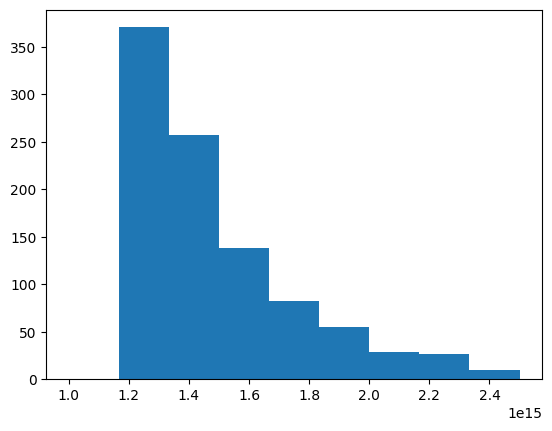

In [9]:
#Shows distribution of masses
plt.hist(mass_list, bins=np.linspace(1*10**15, 2.5*10**15,10))

In [10]:
# Converts colatitude and longitude into declination and right assencion
def read_halo(i):
    lat = np.pi/2 -theta
    return lat[i], phi[i]

In [11]:
# Creates list of coordinates of halos with large masses
big_mass_coords = []
for z in range(len(mass_list)):
    if mass_list[z] >= 1.5*10**15:
        big_mass_coords.append(read_halo(z))

In [12]:
# Tells you how many thumbnails you can stack
len(big_mass_coords)

372

In [13]:
# ONLY RUN ONCE
# Creates a thumbnail centered around given coordinates

def thumbnail_kap(i):
    coords = big_mass_coords[i]
    return reproject.thumbnails(enmap_map_kaps,coords)

def thumbnail_tsz(i):
    coords = big_mass_coords[i]
    return reproject.thumbnails(enmap_map_tsz,coords)

def thumbnail_lensed(i):
    coords = big_mass_coords[i]
    return reproject.thumbnails(enmap_map_lensed,coords)

In [14]:
def averaged_map_kap(k):
    image_list_kap = []
    for z in range(k):
        image_list_kap.append(np.array(thumbnail_kap(z)))
    # Stack the images into a single NumPy array
    stacked_images_kap = np.stack(image_list_kap, axis=0)  # Stack along the first axis (0)
    # Compute the average of the stacked images
    average_image_kap = np.average(stacked_images_kap, axis=0)
    return average_image_kap
    
def averaged_map_tsz(k):
    image_list_tsz = []
    for z in range(k):
        image_list_tsz.append(np.array(thumbnail_tsz(z)))
    # Stack the images into a single NumPy array
    stacked_images_tsz = np.stack(image_list_tsz, axis=0)  # Stack along the first axis (0)
    # Compute the average of the stacked images
    average_image_tsz = np.average(stacked_images_tsz, axis=0)
    return average_image_tsz
    
def averaged_map_lensed(k):
    image_list_lensed = []
    for z in range(k):
        image_list_lensed.append(np.array(thumbnail_lensed(z)))
    # Stack the images into a single NumPy array
    stacked_images_lensed = np.stack(image_list_lensed, axis=0)  # Stack along the first axis (0)
    # Compute the average of the stacked images
    average_image_lensed = np.average(stacked_images_lensed, axis=0)
    return average_image_lensed


In [15]:
# For any i indice, plots each data set as subplots
def averaged_subplots(k):
    average_map_kap = averaged_map_kap(k)
    average_map_tsz = averaged_map_tsz(k)
    average_map_lensed = averaged_map_lensed(k)
    fig, axs = plt.subplots(1, 3)
    im1 = axs[0].imshow(average_map_kap, origin='lower')
    cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.04, orientation='horizontal', pad=0.1)
    im2 = axs[1].imshow(average_map_tsz, origin='lower')
    cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.04, orientation='horizontal', pad=0.1)
    im3 = axs[2].imshow(average_map_lensed, origin='lower')
    cbar3 = fig.colorbar(im3, ax=axs[2], fraction=0.04, orientation='horizontal', pad=0.1)
    axs[0].set_title('Kappa')
    axs[1].set_title('Tsz')
    axs[2].set_title('Lensed Temp')
    return plt.show()

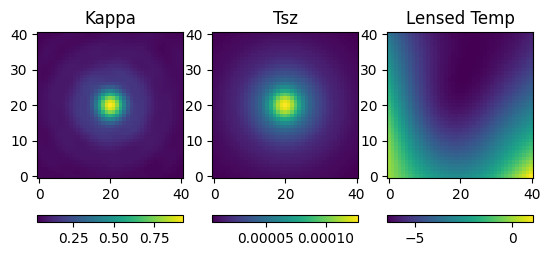

In [16]:
averaged_subplots(350)